**Followed**: https://github.com/mannybernabe/transferLearning_pneumonia/blob/master/Transfer_Learning_Xray_Pneumonia.ipynb

## Pneumonia
Source : Wikipedia
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli. Typically symptoms include some combination of productive or dry cough, chest pain, fever, and trouble breathing. Severity is variable.
Vaccines to prevent certain types of pneumonia are available.Other methods of prevention include handwashing and not smoking.Treatment depends on the underlying cause. Pneumonia believed to be due to bacteria is treated with antibiotics. If the pneumonia is severe, the affected person is generally hospitalized. Oxygen therapy may be used if oxygen levels are low.
Pneumonia affects approximately 450 million people globally (7% of the population) and results in about 4 million deaths per year.
In 2008, pneumonia occurred in approximately 156 million children (151 million in the developing world and 5 million in the developed world).In 2010, it resulted in 1.3 million deaths, or 18% of all deaths in those under five years, of which 95% occurred in the developing world.

## Setup

In [0]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Helper Function

In [0]:
def search_dir(type="normal", num=6):
  #Helper function to scan contents of directory
  counter=0

  for file in os.listdir(train_dir + type.upper()+ "/"):
      if counter == num:
          break

      if file.endswith(".jpeg"):
          print(file)

      counter += 1

In [0]:
def plot_images(type="normal", num=6):
  #Helper function to plot images
  counter=0
  fig = plt.figure(figsize=(10, 8))
  

  for file in os.listdir(train_dir + type.upper()):

      if file.endswith(".jpeg"):
          if counter == num:
              break

          img = mpimg.imread(train_dir + type.upper()+"/"+file)
          plt.subplot(231+counter)
          plt.title(file.split('.')[0])
          imgplot = plt.imshow(img)

          counter += 1

In [0]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

## Download Data

In [0]:
!pip install -q kaggle

from google.colab import files

files.upload()

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = 'xxx'
os.environ['KAGGLE_KEY'] = 'xxxxxx'

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:51<00:00, 45.0MB/s]
100% 2.29G/2.29G [00:51<00:00, 47.8MB/s]


In [0]:
!unzip chest-xray-pneumonia.zip
!unzip chest_xray.zip

In [0]:
os.remove("chest-xray-pneumonia.zip")

## Explore Data

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

In [0]:
#Point to the relevant directories
train_dir = "chest_xray/train/"
test_dir   = "chest_xray/test/" #directories for training

val_dir  = "chest_xray/val/" #directory for final model scoring

In [0]:
search_dir(type="pneumonia", num=10)

person319_virus_645.jpeg
person543_bacteria_2282.jpeg
person702_virus_1299.jpeg
person1475_virus_2558.jpeg
person1771_bacteria_4615.jpeg
person1521_virus_2649.jpeg
person111_virus_209.jpeg
person1243_virus_2110.jpeg
person299_bacteria_1414.jpeg
person1745_bacteria_4584.jpeg


In [0]:
search_dir(type="normal", num=10)

IM-0187-0001.jpeg
NORMAL2-IM-1321-0001.jpeg
NORMAL2-IM-0992-0001.jpeg
NORMAL2-IM-1314-0001.jpeg
NORMAL2-IM-1419-0001.jpeg
IM-0290-0001.jpeg
IM-0516-0001.jpeg
NORMAL2-IM-0969-0001.jpeg
IM-0499-0001.jpeg
IM-0494-0001.jpeg


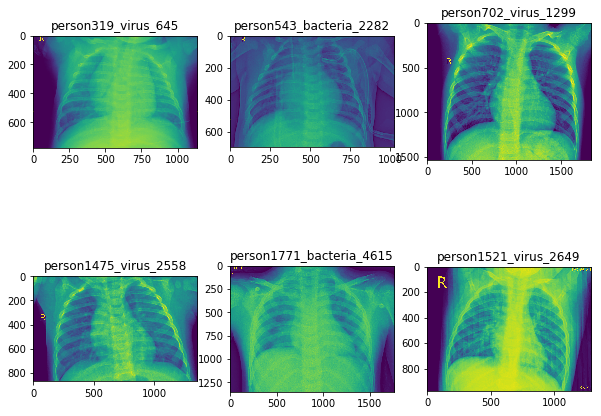

In [0]:
plot_images(type="pneumonia", num=6)

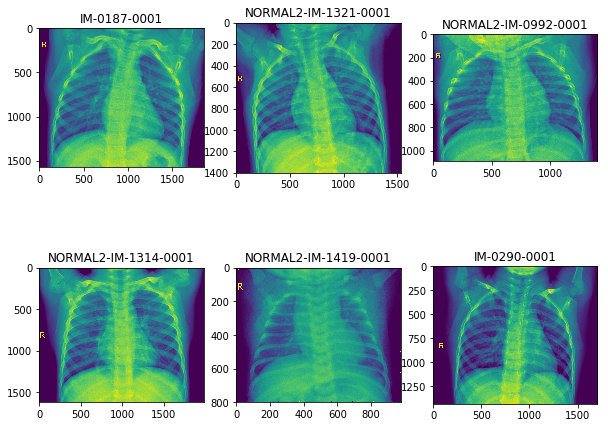

In [0]:
plot_images(type="normal", num=6)

# Modeling


Pre-Trained Model w/o Transfer Learning

In [0]:
import numpy as np

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.python.keras.preprocessing import image

In [0]:
pre_model = InceptionV3(weights='imagenet')

In [0]:
img = image.load_img( "/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg", 
                     target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = pre_model.predict(x)
for index, res in enumerate(decode_predictions(y)[0]):
    print('{}. {}: {:.3f}%'.format(index + 1, res[1], 100 * res[2]))

40960/35363 [==================================] - 0s 0us/step
1. water_bottle: 73.426%
2. isopod: 16.616%
3. scorpion: 1.624%
4. trilobite: 0.468%
5. water_jug: 0.425%


Preparing the data

In [0]:
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size=163


#Create training data generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1) #Create image generator in the abstract

In [0]:
train_generator = train_datagen.flow_from_directory(
        train_dir, #directory that contains training data
        target_size=(150, 150), #what size image we want
        batch_size=batch_size, #how many files to read in at a time
        class_mode="categorical")

Found 5216 images belonging to 2 classes.


In [0]:
#Create validation data generator

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode="categorical")

Found 624 images belonging to 2 classes.


In [0]:
#Create validation test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode="categorical",
        shuffle=False)

Found 16 images belonging to 2 classes.


Train Model

In [0]:
import keras

In [0]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)


for layer in base_model.layers:
  layer.trainable = False  # Freeze the layers not to train
  
final_model = keras.models.Model(inputs=base_model.inputs, outputs=predictions) #create final model

In [0]:
final_model.compile(loss ="categorical_crossentropy", #another term for log loss
                    optimizer = "adam", 
                    metrics=["accuracy"])

In [0]:
fit_history = final_model.fit_generator(
        train_generator, #train data generator 
        steps_per_epoch=len(train_generator),
        epochs=5,
        validation_data=val_generator, #validation data generator 
        validation_steps=len(val_generator))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
32/32 [==============================] - 99s 3s/step - loss: 0.5461 - acc: 0.8384 - val_loss: 1.5408 - val_acc: 0.7115
Epoch 2/5
32/32 [==============================] - 85s 3s/step - loss: 0.2544 - acc: 0.9036 - val_loss: 1.2843 - val_acc: 0.7131
Epoch 3/5
32/32 [==============================] - 88s 3s/step - loss: 0.2255 - acc: 0.9089 - val_loss: 2.1411 - val_acc: 0.6090
Epoch 4/5
32/32 [==============================] - 88s 3s/step - loss: 0.2233 - acc: 0.9133 - val_loss: 1.0234 - val_acc: 0.7179
Epoch 5/5
32/32 [==============================] - 87s 3s/step - loss: 0.2204 - acc: 0.9147 - val_loss: 1.0224 - val_acc: 0.6827


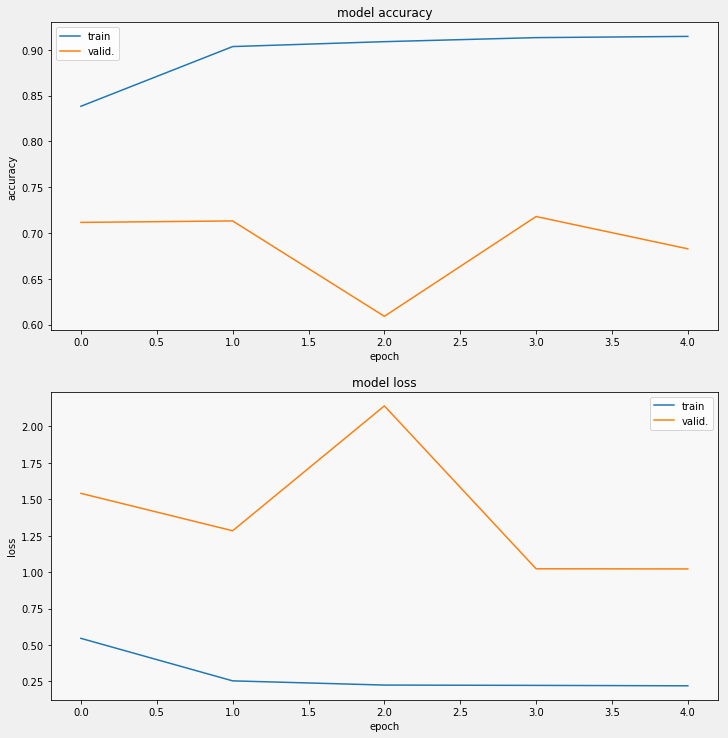

In [0]:
display_training_curves(fit_history.history['acc'], fit_history.history['val_acc'], 'accuracy', 211)
display_training_curves(fit_history.history['loss'], fit_history.history['val_loss'], 'loss', 212)

In [0]:
result  = final_model.evaluate_generator(test_generator,steps=len(test_generator))
print('Loss:', result[0])
print('Accuracy:', result[1])

Loss: 1.17354394674817
Accuracy: 0.75


In [0]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [0]:
#Generate all predictions
filenames = test_generator.filenames
nb_samples = len(filenames)
predict = final_model.predict_generator(test_generator,steps = nb_samples).argmax(axis=-1)

predict

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [0]:
#Generate true labels
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

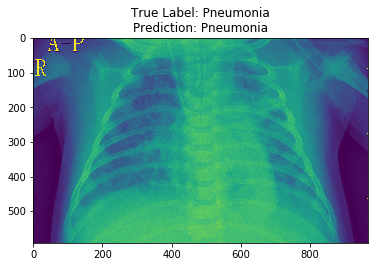

In [0]:
#@title Enter Filepath Here:
filename = "/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg" #@param {type:"string"}

img = image.load_img(filename, 
                     target_size=(150, 150))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = final_model.predict(x)

predicton="Normal" if y.argmax(axis=-1)==0 else "Pneumonia"
actual="Normal" if "NORMAL" in filename else "Pneumonia" 

img=mpimg.imread(filename)
title_text = ("%s%s%s%s%s"%("True Label: ", actual, "\n", "Prediction: ", predicton))
plt.title(title_text)
imgplot=plt.imshow(img)